<a href="https://colab.research.google.com/github/TWAAXOne/Network-intrusion-detection-with-machine-learning/blob/main/CNN_multiclass_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# Forcer l'utilisation de Tensorflow 2.x
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [38]:
# Install les packages nécessaires
!pip install bayesian-optimization
!pip install mlxtend --upgrade --no-deps

### Import des librairies

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from keras import backend as K
from keras.layers import Input
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from keras import Model

# Ordinateur Local
# from keras.src.layers import BatchNormalization, ReLU, Conv2D, Flatten, Dense, concatenate

# Google Colab
from google.colab import drive
from tensorflow.keras.layers import BatchNormalization, ReLU, Conv2D, Flatten, Dense, concatenate


### Import des données

#### Import des données Local

In [40]:
# Import des données Local
# data_train = pd.read_csv('Data/UNSW-NB15 - CSV Files/a part of training and testing set/UNSW_NB15_training-set.csv',
#                          low_memory=False)
# data_test = pd.read_csv('Data/UNSW-NB15 - CSV Files/a part of training and testing set/UNSW_NB15_testing-set.csv',
#                         low_memory=False)

#### Import des données Google Colab

In [41]:
# Récupérer son drive Google
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# Import des données Google Colab
# Path
path_train = "/content/drive/MyDrive/Data/UNSW_NB15_training-set.csv"
path_test = "/content/drive/MyDrive/Data/UNSW_NB15_testing-set.csv"

# Import des données
data_train = pd.read_csv(path_train,dtype='unicode')
data_test = pd.read_csv(path_test,dtype='unicode')

In [43]:
# On fusionne les deux datasets
data = pd.concat([data_train, data_test], axis=0)

# On supprime les colonnes inutiles
data.drop('id', axis=1, inplace=True)
data.drop('label', axis=1, inplace=True)

### Analyse des données

In [44]:
# Affichage des données
data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,...,1,1,2,0,0,0,1,2,0,Normal
1,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,...,1,1,2,0,0,0,1,2,0,Normal
2,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,...,1,1,3,0,0,0,1,3,0,Normal
3,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,...,2,1,3,0,0,0,2,3,0,Normal
4,0.00001,udp,-,INT,2,0,2126,0,100000.0025,254,...,2,1,3,0,0,0,2,3,0,Normal


In [45]:
# Taille du dataset
print("Taille du dataset : ", data.shape)
print("Nom des colonnes : ", data.columns)
print("Nombre de valeurs nulles : ", data.isnull().sum().sum())

Taille du dataset :  (257673, 43)
Nom des colonnes :  Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat'],
      dtype='object')
Nombre de valeurs nulles :  0


Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: attack_cat, dtype: int64

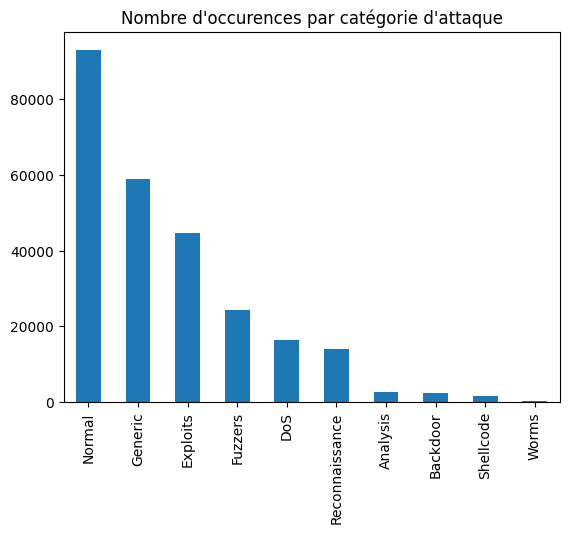

In [46]:
# Visualisation des données
display(data['attack_cat'].value_counts())
data_plot = data['attack_cat'].value_counts().plot(kind='bar', title="Nombre d'occurences par catégorie d'attaque")

### Préparation des données
Les données ne sont pas prêtes à être utilisées par un réseau de neurones. Il faut donc les préparer.

In [47]:
# Transformations des valeurs catégorielles en valeurs numériques
def encode_string_byte(df, col_name):
    encoder = LabelEncoder()  # Outils pour encoder les valeurs catégorielles
    # fit → permet d'apprendre les différentes valeurs possibles
    # transform → permet de remplacer les valeurs par les valeurs numériques
    df[col_name] = encoder.fit_transform(df[col_name])


# 3 colonnes catégorielles contenant des valeurs textuelles
encode_string_byte(data, 'proto')
encode_string_byte(data, 'state')
encode_string_byte(data, 'service')

print("Colonne 'Proto' --> Valeur max : {} Valeur min : {}".format(max(data['proto']), min(data['proto'])))
print("Colonne 'State' --> Valeur max : {} Valeur min : {}".format(max(data['state']), min(data['state'])))
print("Colonne 'Service' --> Valeur max : {} Valeur min : {}".format(max(data['service']), min(data['service'])))

Colonne 'Proto' --> Valeur max : 132 Valeur min : 0
Colonne 'State' --> Valeur max : 10 Valeur min : 0
Colonne 'Service' --> Valeur max : 12 Valeur min : 0


In [48]:
# Normalisation des données
# Permet de ramener les valeurs entre 0 et 1, pour éviter que certaines valeurs aient plus d'importance que d'autres
def normalize(df, col_name):
    x = df[col_name].values.astype(float)  # On récupère les valeurs de la colonne, et on les convertit en float
    min_max_scaler = preprocessing.MinMaxScaler()  # Outils pour normaliser les valeurs
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1, 1))  # On normalise les valeurs
    # x.reshape(-1, 1) permet de convertir un vecteur en matrice
    df[col_name] = x_scaled


normalize(data, 'dur')
normalize(data, 'spkts')
normalize(data, 'dpkts')
normalize(data, 'sbytes')
normalize(data, 'dbytes')
normalize(data, 'rate')
normalize(data, 'sttl')
normalize(data, 'dttl')
normalize(data, 'sload')
normalize(data, 'dload')
normalize(data, 'sloss')
normalize(data, 'dloss')
normalize(data, 'sinpkt')
normalize(data, 'dinpkt')
normalize(data, 'sjit')
normalize(data, 'djit')
normalize(data, 'swin')
normalize(data, 'stcpb')
normalize(data, 'dtcpb')
normalize(data, 'dwin')
normalize(data, 'tcprtt')
normalize(data, 'synack')
normalize(data, 'ackdat')
normalize(data, 'smean')
normalize(data, 'dmean')
normalize(data, 'trans_depth')
normalize(data, 'response_body_len')
normalize(data, 'ct_srv_src')
normalize(data, 'ct_state_ttl')
normalize(data, 'ct_dst_ltm')
normalize(data, 'ct_src_dport_ltm')
normalize(data, 'ct_dst_sport_ltm')
normalize(data, 'ct_dst_src_ltm')
normalize(data, 'is_ftp_login')
normalize(data, 'ct_ftp_cmd')
normalize(data, 'ct_flw_http_mthd')
normalize(data, 'ct_src_ltm')
normalize(data, 'ct_srv_dst')
normalize(data, 'is_sm_ips_ports')

In [49]:
# Quantification des données
# Permet de transformer les valeurs continues en valeurs discrètes (0 à 255)
# + Réduction de la complexité des données, + réduction du bruit, + Rapide à calculer, - Perte d'information, - Perte de précision

def quantification_0_255(df, col_name):
    x = df[col_name].values.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler((0, 255))
    x_0_255 = min_max_scaler.fit_transform(x.reshape(-1, 1)).astype(int)
    df[col_name] = x_0_255


quantification_0_255(data, 'dur')
quantification_0_255(data, 'spkts')
quantification_0_255(data, 'dpkts')
quantification_0_255(data, 'sbytes')
quantification_0_255(data, 'dbytes')
quantification_0_255(data, 'rate')
quantification_0_255(data, 'sttl')
quantification_0_255(data, 'dttl')
quantification_0_255(data, 'sload')
quantification_0_255(data, 'dload')
quantification_0_255(data, 'sloss')
quantification_0_255(data, 'dloss')
quantification_0_255(data, 'sinpkt')
quantification_0_255(data, 'dinpkt')
quantification_0_255(data, 'sjit')
quantification_0_255(data, 'djit')
quantification_0_255(data, 'swin')
quantification_0_255(data, 'stcpb')
quantification_0_255(data, 'dtcpb')
quantification_0_255(data, 'dwin')
quantification_0_255(data, 'tcprtt')
quantification_0_255(data, 'synack')
quantification_0_255(data, 'ackdat')
quantification_0_255(data, 'smean')
quantification_0_255(data, 'dmean')
quantification_0_255(data, 'trans_depth')
quantification_0_255(data, 'response_body_len')
quantification_0_255(data, 'ct_srv_src')
quantification_0_255(data, 'ct_state_ttl')
quantification_0_255(data, 'ct_dst_ltm')
quantification_0_255(data, 'ct_src_dport_ltm')
quantification_0_255(data, 'ct_dst_sport_ltm')
quantification_0_255(data, 'ct_dst_src_ltm')
quantification_0_255(data, 'is_ftp_login')
quantification_0_255(data, 'ct_ftp_cmd')
quantification_0_255(data, 'ct_flw_http_mthd')
quantification_0_255(data, 'ct_src_ltm')
quantification_0_255(data, 'ct_srv_dst')
quantification_0_255(data, 'is_sm_ips_ports')

In [50]:
# Stockage dans la variable y V1
# Puisque attack_cat est une variable catégorielle, on va la transformer en variable numérique
#label_encoder = LabelEncoder()  # Outils pour encoder les étiquettes textuelles en étiquettes numériques
#label_binarizer = LabelBinarizer()  # Outils pour encoder les étiquettes numériques en étiquettes binaires

#label = data['attack_cat'].values

# Encodage des étiquettes textuelles en étiquettes numériques
#label_encoder.fit(label)
#y = label_encoder.transform(label)

# Transformation des étiquettes numériques en étiquettes binaires
#label_binarizer.fit(y)
#y = label_binarizer.transform(y)

#y = pd.DataFrame(y)

In [51]:
# Suppression de la colonne 'attack_cat' et stockage dans la variable y
y_column = data['attack_cat']
data.drop('attack_cat', axis=1, inplace=True)
dummies = pd.get_dummies(y_column)
y = dummies.values
dummies.head()

,Analysis,Backdoor,DoS,Exploits,Fuzzers,Generic,Normal,Reconnaissance,Shellcode,Worms
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0


### Transformation des données en Images
Les CNN sont spécialement adapté au traitement des images. Nous allons donc transformer nos données en images pour pouvoir les traiter avec un CNN.

In [52]:
# La longueur de notre dataset est de 42 colonnes et de 257673 lignes
print(data.shape)

(257673, 42)


In [53]:
# Chaque ligne aura une longueur de 64 valeurs
# Actuellement, chaque ligne est composée de 42 valeurs donc nous ajoutons 22 valeurs pour arriver à 64
# (0,0) : 0 ligne ajoutée à gauche, 0 ligne ajoutée à droite
# (0,22) : 0 colonne ajoutée à gauche, 22 colonnes ajoutées à droite
# 'constant' : Les valeurs ajoutées sont des 0
byte_images = np.pad(data.to_numpy(), ((0, 0), (0, 22)), 'constant')
print(byte_images.shape)

(257673, 64)


Image normale :
Normal Output


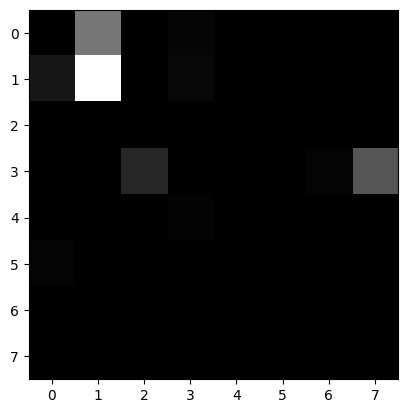

Generic Output


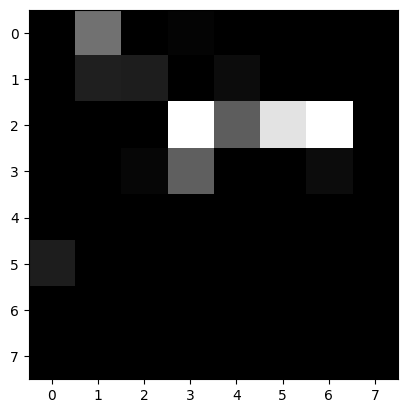

Exploits Output


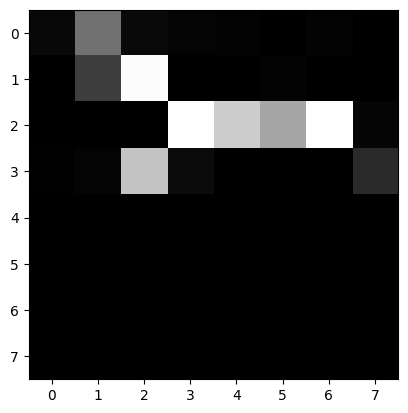

Fuzzers Output


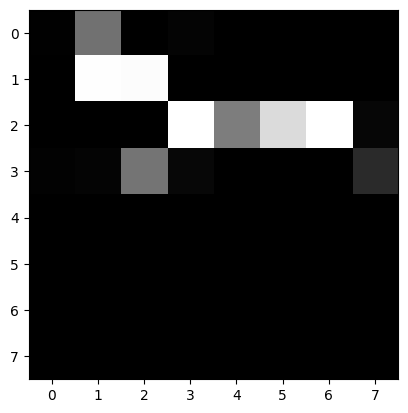

DoS Output


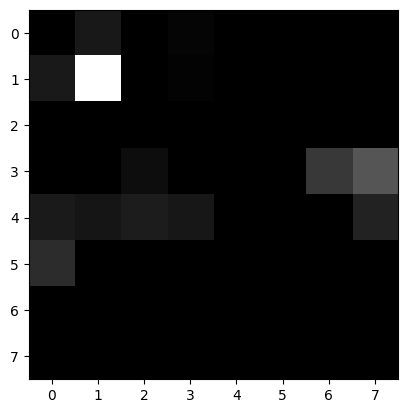

Reconnaissance Output


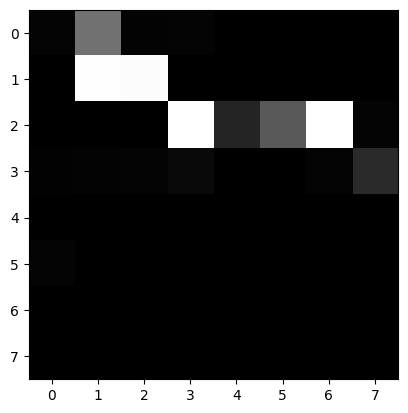

Analysis Output


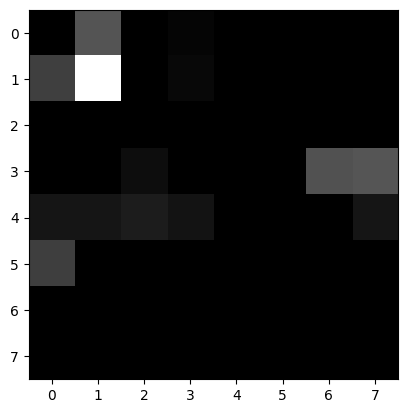

Backdoor Output


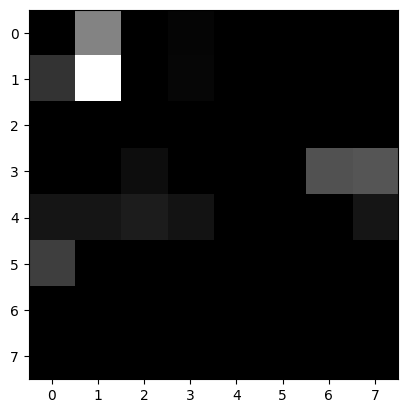

Shellcode Output


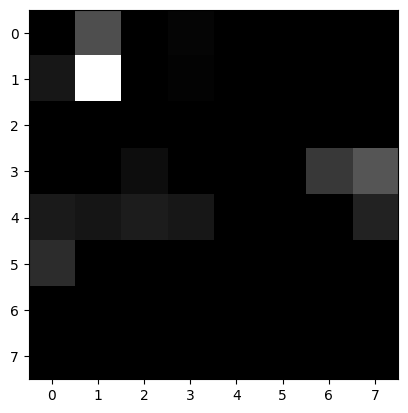

Worms Output


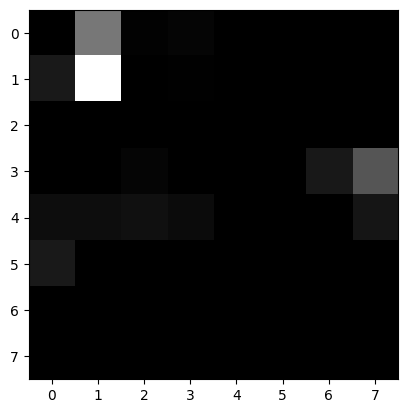

In [54]:
# Plot d'une image
def plot_single_image(byte_image):
    grayImage = byte_image.reshape(8, 8)  # On redimensionne l'image
    plt.imshow(grayImage, cmap="gray")  # On affiche l'image avec une colormap en niveau de gris
    plt.show()  # On affiche l'image


print("Image normale :")
print("Normal Output")
plot_single_image(byte_images[0])  # index 0 = Normal
print("Generic Output")
plot_single_image(byte_images[117204])
print("Exploits Output")
plot_single_image(byte_images[48932])
print("Fuzzers Output")
plot_single_image(byte_images[48017])
print("DoS Output")
plot_single_image(byte_images[48999])
print("Reconnaissance Output")
plot_single_image(byte_images[48866])
print("Analysis Output")
plot_single_image(byte_images[47932])
print("Backdoor Output")
plot_single_image(byte_images[47911])
print("Shellcode Output")
plot_single_image(byte_images[48813])
print("Worms Output")
plot_single_image(byte_images[49959])

In [55]:
byte_images[0]

array([  0, 119,   0,   5,   0,   0,   0,   0,  23, 254,   0,   7,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        38,   0,   0,   0,   4,  85,   0,   0,   0,   3,   0,   0,   0,
         0,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

- On refait une étape de normalisation pour avoir des valeurs entre -0.5 et 0.5. L'objectif c'est de facilité l'apprentissage du CNN, car les données centrées autour du 0 peuvent améliorer la convergence et la stabilité de l'apprentissage. De plus on évite les valeurs extrêmes.
- Réquilibrage avec SMOTE, cela permet d'équilibrer les classes en créant des données synthétiques.
- Le CNN prend en entrée des matrices. Actuellement, nos données sont des vecteurs. Nous allons donc les transformer en matrice de taille 8x8x1.

In [56]:
# Normalisation
x = []
for image in np.array(byte_images):
    x.append((image / 255 - 0.5)) # Normalisation des valeurs entre -0.5 et 0.5

# Réquilibrage des classes avec SMOTE
sm = SMOTE(random_state=0)
x, y = sm.fit_resample(x, y)  # ajuste et applique le rééchantillonnage

# Transformation de x en matrice
x = np.array(x)
# x.shape = (930'000, 64)
x = x.reshape(x.shape[0], 8, 8, 1)
# Transforme le vecteur x en une matrice 4D de taille (930'000, 8, 8, 1)
# chaque element de la liste x est un vecteur de taille 64, nous la transformons en un carré donc 8x8.
# 1 car nous avons une seule couleur (niveau de gris)

### Préparation de la création du modèle

In [57]:
def plot_accuracies(nets, history, names, y_accuracy):
    """
    Affiche un graphique des précisions de validation pour différents modèles
    sur plusieurs époques d'entraînement.

    :param nets: Nombre total de modèles à afficher.
    :param history: Liste contenant l'historique d'entraînement pour chaque modèle.
    :param names: Liste des noms des modèles.
    :param y_accuracy: Limites pour l'axe des ordonnées (précision).
    """
    # Initialisation de la figure
    plt.figure(figsize=(15, 5))
    # Liste de couleurs pour les différentes courbes
    color = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    # Boucle pour tracer la précision de validation pour chaque modèle
    for i in range(nets):
        plt.plot(history[i].history['val_accuracy'], linestyle='--', color=color[i])
    # Titre et étiquettes pour les axes
    plt.title('Précision du modèle')
    plt.ylabel('Précision')
    plt.xlabel('Époque')
    # Légende du graphique
    plt.legend(names, loc='upper left')
    # Configuration de l'axe des ordonnées et activation de la grille
    axes = plt.gca()
    axes.set_ylim(y_accuracy)
    plt.grid(True)
    # Affichage du graphique
    plt.show()


In [58]:
# Fonction d'activation Swish
def swish(x):
    return (K.sigmoid(x) * x)

# get_custom_objects().update({'swish': Activation(swish)}), je ne trouve pas l'import
# A faire: model.add(Dense(64, activation=swish))
# model = load_model('path_to_model.h5', custom_objects={'swish': swish})

In [59]:
# Séparation des données en données d'entraînement et données de test
# StratifiedShuffleSplit permet de conserver la même proportion de classes dans les données d'entraînement et de test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(x, y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

### Création du modèle
Création de 3 variants de modèles CNN avec des architectures différentes. basée sur le nombre de bloc VGG qu'ils contiennent. Chaque bloc VGG est composé d'une serie de couche de convolution suivies d'une couche de pooling.

In [63]:
nets = 3  # Nombre de modèle
model = [0] * nets  # Liste des modèles
history = [0] * nets  # Liste des historiques d'entraînement pour chaque modèle
names = ["1_block", "2_blocks", "3_blocks"]

epochs = 20  # Nombre d'époques d'entraînement → nombre de fois qu'il va parcourir l'ensemble des données d'entraînement
batch_size = 128  # Nombre d'images à traiter avant de mettre à jour les poids du réseau de neurones

# Boucle pour créer les modèles
for net in range(nets):
    if net == 0:  # modèle 1
        input_img = Input(shape=(8, 8, 1))  # Définition de la structure de l'entrée du modèle

        ### Block
        # BatchNormalization permet de normaliser les activations, ce qui permet d'accélérer l'apprentissage
        # Mais est secondaire, car les données d'entrée sont déjà normalisées autour de 0.
        block_1 = BatchNormalization()(input_img)

        # ReLu ce qui garentie que les valeurs de sortie sont positives
        block_1 = ReLU()(block_1)

        # Conv2D permet de créer une couche de convolution
        # 32 est le nombre de filtres de convolution
        # (3,3) est la taille de la fenêtre de convolution
        # padding='same' permet de conserver la taille de l'image en sortie
        block_1 = Conv2D(32, (3,3), padding='same')(block_1)

        block_1 = BatchNormalization()(block_1)  # Permet d'accélérer l'apprentissage
        block_1 = ReLU()(block_1)
        block_1 = Conv2D(32, (3,3), padding='same')(block_1)
        ### Fin block

        output = Flatten()(block_1)  # Permet de transformer la matrice en vecteur
        output = Dense(128, activation='relu')(output)  # Couche de sortie avec 128 neurones et fonction d'activation relu
        out = Dense(10, activation='softmax')(output)  # Couche de sortie avec 10 neurones (1 par classe) et fonction d'activation softmax
    if net == 1:
        input_img = Input(shape = (8, 8, 1))

        ### Block 1
        block_1 = BatchNormalization()(input_img)
        block_1 = ReLU()(block_1)
        block_1 = Conv2D(32, (3,3), padding='same')(block_1)
        block_1 = BatchNormalization()(block_1)
        block_1 = ReLU()(block_1)
        block_1 = Conv2D(32, (3,3), padding='same')(block_1)
        ### Fin block 1

        concat_1 =concatenate([input_img, block_1], axis = 3)
        # Concatenate permet de fusionne l'entrée du modèle et la sortie du bloc 1
        # permet de conserver les informations de l'entrée du modèle

        ### Block 2
        block_2 = BatchNormalization()(concat_1)
        block_2 = ReLU()(block_2)
        block_2 = Conv2D(64, (3,3), padding='same')(block_2)
        block_2 = BatchNormalization()(block_2)
        block_2 = ReLU()(block_2)
        block_2 = Conv2D(64, (3,3), padding='same')(block_2)
        ### Fin block 2

        output = Flatten()(block_2)
        output = Dense(128, activation='relu')(output)
        out    = Dense(10, activation='softmax')(output)
    if net == 2 :
        input_img = Input(shape = (8, 8, 1))

        ### Block 1
        block_1 = BatchNormalization()(input_img)
        block_1 = ReLU()(block_1)
        block_1 = Conv2D(32, (3,3), padding='same')(block_1)
        block_1 = BatchNormalization()(block_1)
        block_1 = ReLU()(block_1)
        block_1 = Conv2D(32, (3,3), padding='same')(block_1)
        ### Fin block 1

        concat_1 =concatenate([input_img, block_1], axis = 3)

        ### Block 2
        block_2 = BatchNormalization()(concat_1)
        block_2 = ReLU()(block_2)
        block_2 = Conv2D(64, (3,3), padding='same')(block_2)
        block_2 = BatchNormalization()(block_2)
        block_2 = ReLU()(block_2)
        block_2 = Conv2D(64, (3,3), padding='same')(block_2)
        ### Fin block 2

        concat_2 =concatenate([input_img, block_1,block_2], axis = 3)

        ### Block 3
        block_3 = BatchNormalization()(concat_2)
        block_3 = ReLU()(block_3)
        block_3 = Conv2D(128, (3,3), padding='same')(block_3)
        block_3 = BatchNormalization()(block_3)
        block_3 = ReLU()(block_3)
        block_3 = Conv2D(128, (3,3), padding='same',strides=(2,2))(block_3)
        ### Fin block 3

        output = Flatten()(block_3)
        output = Dense(128, activation='relu')(output)
        out    = Dense(10, activation='softmax')(output)

    model[net] = Model(inputs = input_img, outputs = out)
    model[net].summary()
    model[net].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history[net] = model[net].fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,batch_size=batch_size,epochs=epochs)

    score = model[net].evaluate(x_test, y_test, verbose=0)
    print ("")
    print("CNN: {}, Epochs={}, Batch_size={}, Test loss={}, Test accuracy={}".format(names[net],epochs,batch_size,score[0],score[1]))
    print ("")


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8, 8, 1)]         0         
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 1)          4         
 hNormalization)                                                 
                                                                 
 re_lu_4 (ReLU)              (None, 8, 8, 1)           0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 32)          320       
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 32)         128       
 hNormalization)                                                 
                                                                 
 re_lu_5 (ReLU)              (None, 8, 8, 32)          0   

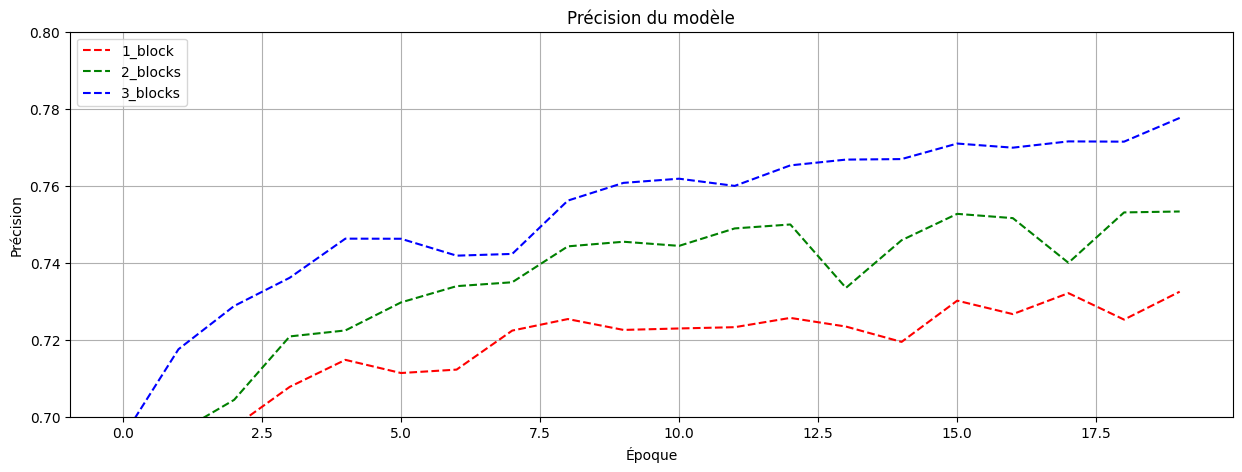

In [65]:
plot_accuracies (nets,history,names,[0.7,0.8])

Nous pouvons remarquer que le model le plus performant est le modèle avec 3 bloc. Cependant, il est plus long à entrainer.
Nous allons tous de même continuer avec un modèle à 3 bloc comme référence.
Le but actuel est de déterminer le nombre de filtre optimal.

In [66]:
nets = 6  # Nombre de modèle
model = [0] * nets  # Liste des modèles
history = [0] * nets  # Liste des historiques d'entraînement pour chaque modèle
names = ["8 maps", "16 maps", "24 maps", "32 maps", "48 maps", "64 maps"]  # Noms des modèles

epochs = 20  # Nombre d'époques d'entraînement → nombre de fois qu'il va parcourir l'ensemble des données d'entraînement
batch_size = 128  # Nombre d'images à traiter avant de mettre à jour les poids du réseau de neurones

# Boucle pour créer les modèles
for net in range(nets):
    if net == 2 :
        input_img = Input(shape = (8, 8, 1))

        ### Block 1
        block_1 = BatchNormalization()(input_img)
        block_1 = ReLU()(block_1)
        # net*8+8 permet de faire varier le nombre de filtre
        block_1 = Conv2D(net*8+8, (3,3), padding='same')(block_1)
        block_1 = BatchNormalization()(block_1)
        block_1 = ReLU()(block_1)
        block_1 = Conv2D(net*8+8, (3,3), padding='same')(block_1)
        ### Fin block 1

        concat_1 =concatenate([input_img, block_1], axis = 3)

        ### Block 2
        block_2 = BatchNormalization()(concat_1)
        block_2 = ReLU()(block_2)
        block_2 = Conv2D(net*16+16, (3,3), padding='same')(block_2)
        block_2 = BatchNormalization()(block_2)
        block_2 = ReLU()(block_2)
        block_2 = Conv2D(net*16+16, (3,3), padding='same')(block_2)
        ### Fin block 2

        concat_2 =concatenate([input_img, block_1,block_2], axis = 3)

        ### Block 3
        block_3 = BatchNormalization()(concat_2)
        block_3 = ReLU()(block_3)
        block_3 = Conv2D(net*32+32, (3,3), padding='same')(block_3)
        block_3 = BatchNormalization()(block_3)
        block_3 = ReLU()(block_3)
        block_3 = Conv2D(net*32+32, (3,3), padding='same',strides=(2,2))(block_3)
        ### Fin block 3

        output = Flatten()(block_3)
        output = Dense(128, activation='relu')(output)
        out    = Dense(10, activation='softmax')(output)

    model[net] = Model(inputs = input_img, outputs = out)
    model[net].summary()
    model[net].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history[net] = model[net].fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,batch_size=batch_size,epochs=epochs)

    score = model[net].evaluate(x_test, y_test, verbose=0)
    print ("")
    print("CNN: {}, Epochs={}, Batch_size={}, Test loss={}, Test accuracy={}".format(names[net],epochs,batch_size,score[0],score[1]))
    print ("")

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 8, 8, 1)]    0           []                               
                                                                                                  
 batch_normalization_11 (BatchN  (None, 8, 8, 1)     4           ['input_6[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 re_lu_10 (ReLU)                (None, 8, 8, 1)      0           ['batch_normalization_11[0][0]'] 
                                                                                                  
 conv2d_10 (Conv2D)             (None, 8, 8, 32)     320         ['re_lu_10[0][0]']         

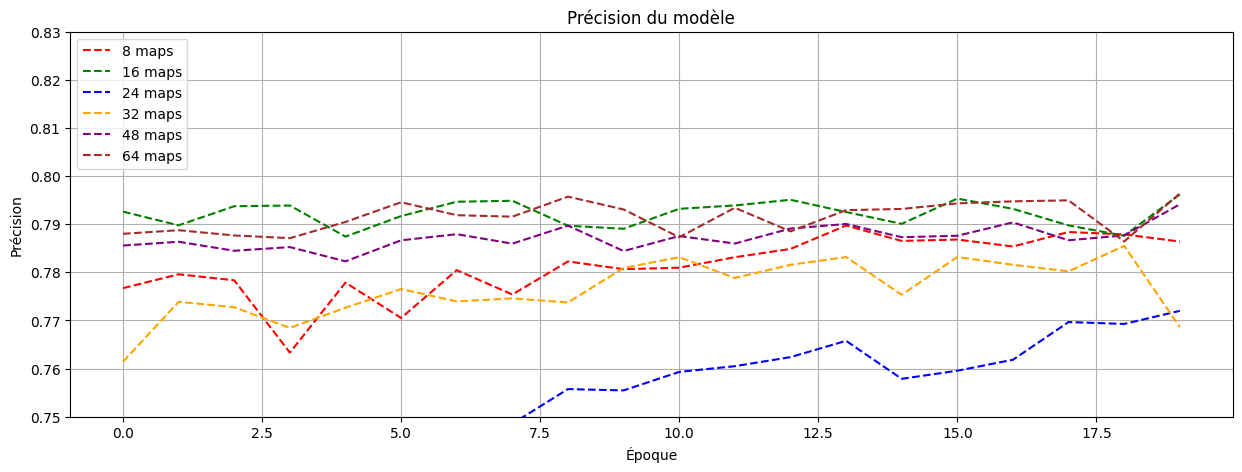

In [67]:
plot_accuracies (nets,history,names,[0.75,0.83])

Nous observons que l'utilisation de 8 filtres donne la précision la plus basse. Cependant, avec 16 filtres, nous obtenons une performance presque équivalente à celle des autres configurations testées. Étant donné que le modèle avec 16 filtres est moins complexe que les autres tout en offrant des résultats similaires, nous le considérons comme la meilleure option.

Le but actuel sera de déterminer le nombre idéal de couche interconnecté (1, 2, 3 ou 4)

In [68]:
nets = 7
model = [0]*nets
history = [0]*nets
names = ["1_dense_layer","2_dense_layer","3_dense_layer","4_dense_layer"]

epochs = 20
batch_size = 128

for net in range(nets):

  input_img = Input(shape = (8, 8, 1))

  ### Bloc 1
  block_1 = BatchNormalization()(input_img)
  block_1 = ReLU()(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)
  block_1 = BatchNormalization()(block_1)
  block_1 = ReLU()(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)
  ### Fin block 1

  concat_1 =concatenate([input_img, block_1], axis = 3)

  ### Bloc 2
  block_2 = BatchNormalization()(concat_1)
  block_2 = ReLU()(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)
  block_2 = BatchNormalization()(block_2)
  block_2 = ReLU()(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)
  ### Fin bloc 2

  concat_2 =concatenate([input_img, block_1,block_2], axis = 3)

  ### Bloc 3
  block_3 = BatchNormalization()(concat_2)
  block_3 = ReLU()(block_3)
  block_3 = Conv2D(64, (3,3), padding='same')(block_3)
  block_3 = BatchNormalization()(block_3)
  block_3 = ReLU()(block_3)
  block_3 = Conv2D(64, (3,3), padding='same',strides=(2,2))(block_3)
  ### Fin bloc 3

  output = Flatten()(block_3)

  if net == 0:
    out    = Dense(10, activation='softmax')(output)
  if net == 1:
    output = Dense(128, activation='relu')(output)
    out    = Dense(10, activation='softmax')(output)
  if net == 2:
    output = Dense(256, activation='relu')(output)
    output = Dense(128, activation='relu')(output)
    out    = Dense(10, activation='softmax')(output)
  if net == 3:
    output = Dense(512, activation='relu')(output)
    output = Dense(256, activation='relu')(output)
    output = Dense(128, activation='relu')(output)
    out    = Dense(10, activation='softmax')(output)

  model[net] = Model(inputs = input_img, outputs = out)
  model[net].summary()
  model[net].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  history[net] = model[net].fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,batch_size=batch_size,epochs=epochs)

  score = model[net].evaluate(x_test, y_test, verbose=0)
  print ("")
  print("CNN {}: Epochs={}, Batch_size={}, Test loss={}, Test accuracy={}".format(names[net],epochs,batch_size,score[0],score[1]))
  print ("")

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 8, 8, 1)]    0           []                               
                                                                                                  
 batch_normalization_23 (BatchN  (None, 8, 8, 1)     4           ['input_8[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 re_lu_22 (ReLU)                (None, 8, 8, 1)      0           ['batch_normalization_23[0][0]'] 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 8, 8, 16)     160         ['re_lu_22[0][0]']        

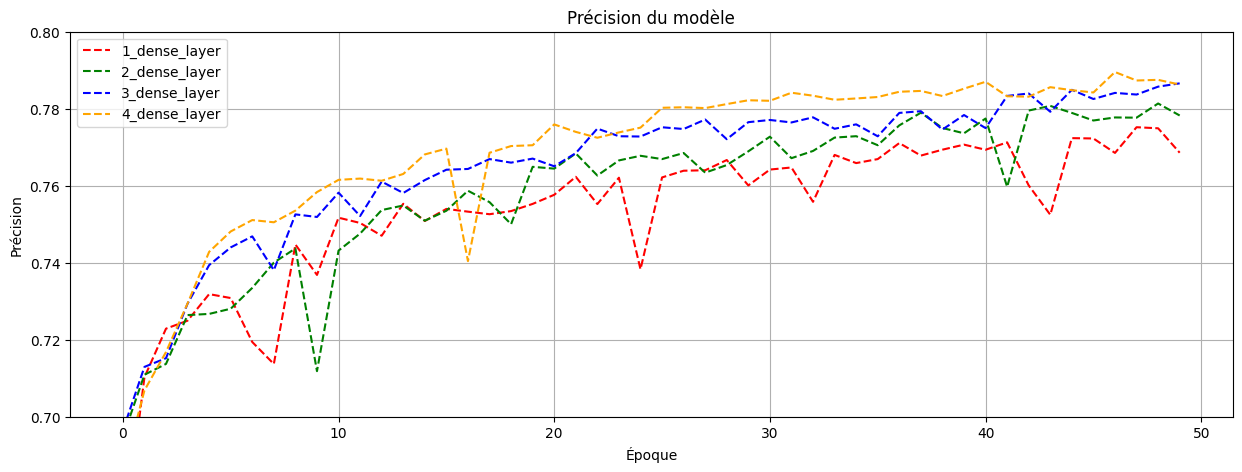

In [72]:
plot_accuracies (nets,history,names,[0.70,0.80])

Le nombre optimal de couches entièrement connectées (Dense) est de 3. En effet, une architecture avec 3 couches offre une performance supérieure à celle avec 1 ou 2 couches, tout en étant moins complexe qu'une structure avec 4 couches.

L'objectif du test suivant est de déterminer le nombre optimal de neurones pour les couches entièrement connectées.

In [ ]:
nets = 7
model = [0] *nets
history = [0] * nets
names = ["32N","64N","128N","256N","512N","1024N","2048N"]

epochs = 20
batch_size = 128


for net in range(nets):
  input_img = Input(shape = (8, 8, 1))

  ### Bloc 1
  block_1 = BatchNormalization()(input_img)
  block_1 = ReLU()(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)
  block_1 = BatchNormalization()(block_1)
  block_1 = ReLU()(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)
  ### Fin Bloc 1

  concat_1 =concatenate([input_img, block_1], axis = 3)

  ### Bloc 1
  block_2 = BatchNormalization()(concat_1)
  block_2 = ReLU()(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)
  block_2 = BatchNormalization()(block_2)
  block_2 = ReLU()(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)

  concat_2 =concatenate([input_img, block_1,block_2], axis = 3)

  block_3 = BatchNormalization()(concat_2)
  block_3 = ReLU()(block_3)
  block_3 = Conv2D(64, (3,3), padding='same')(block_3)
  block_3 = BatchNormalization()(block_3)
  block_3 = ReLU()(block_3)
  block_3 = Conv2D(64, (3,3), padding='same',strides=(2,2))(block_3)

  output = Flatten()(block_3)
  output = Dense(2**(net+5), activation='relu')(output)
  output = Dense((2**(net+5))/2, activation='relu')(output)
  out    = Dense(10, activation='softmax')(output)

  model[net] = Model(inputs = input_img, outputs = out)
  model[net].summary()
  model[net].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  history[net] = model[net].fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,batch_size=batch_size,epochs=epochs)

  score = model[net].evaluate(x_test, y_test, verbose=0)
  print ("")
  print("CNN {}: Epochs={}, Batch_size={}, Test loss={}, Test accuracy={}".format(names[net],epochs,batch_size,score[0],score[1]))
  print ("")